In [1]:
import time
start = time.time()
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glacierml as gl
from tqdm import tqdm
pd.set_option('display.max_column',None)

2024-03-14 13:31:14.194338: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 13:31:14.240010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 13:31:14.850298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
E_delta_a, areas, cols, train = gl.load_LOO_data(include_train = True)
E_delta_a, areas, cols, df = gl.load_LOO_data(include_train = False)

R = ((train[cols]/1e3) - (train['Thickness']/1e3)) /( train['Thickness']/1e3)

var_H = np.mean(np.var(R,axis = 1)) * np.mean(df[cols]/1e3,axis = 1)**2

var_eps_H = np.var(df[cols]/1e3,axis = 1)

E_H = np.mean(df[cols]/1e3,axis = 1)
A = df['Area']

k = 3
p = 0.7
e1 = 0.039
sig_A = k*e1*(A**p)

In [3]:
g1 = (var_H * sig_A**2)
g2 = (E_H**2 * sig_A**2)
g3 = (A**2 * var_H)
g4 = (var_eps_H * sig_A**2)
g5 = (A**2 * var_eps_H)


f = (
    (var_H * sig_A**2) + (E_H**2 * sig_A**2) + (A**2 * var_H) + 
    (var_eps_H * sig_A**2) + (A**2 * var_eps_H)
)

In [4]:
df = pd.concat([df,pd.Series(f,name = 'sig_sq')],axis = 1)

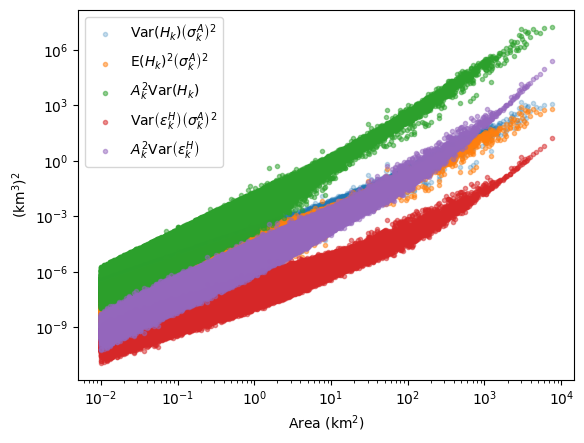

In [132]:
plt.scatter(df['Area'],g1,alpha = 0.25,
            label = r'Var$\left(H_k\right)\left(\sigma^A_k\right)^2$',
            marker = '.'
           )
plt.scatter(
    df['Area'],g2,alpha = 0.5,label = r'E$\left(H_k\right)^2\left(\sigma^A_k\right)^2$',
    marker = '.'
)
plt.scatter(
    df['Area'],g3,alpha = 0.5,
    label = r'$A^2_k$Var$\left(H_k\right)$',
    marker = '.'
)
plt.scatter(
    df['Area'],g4,alpha = 0.5,
    label = r'Var$\left(\epsilon^H_k\right)\left(\sigma^A_k\right)^2$',
    marker = '.'
)
plt.scatter(
    df['Area'],g5,alpha = 0.5,
    label = r'$A_k^2$Var$\left(\epsilon^H_k\right)$',
    marker = '.'
)
plt.xlabel('Area (km$^2$)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('(km$^3$)$^2$')
plt.legend()

In [44]:
h = np.mean(df[cols] / 1e3,axis = 1)
A = df['Area']

si = df['sig_sq']

se = np.sqrt(len(df)*np.var(h*A))

c = (1.96)
Vlb = np.round( np.sum(h * A) - (c * se) , 0) / 1e3
Vub = np.round( np.sum(h * A) + (c * se) , 0) / 1e3

print(f'[{Vlb},{Vub}]  * 10^3 km^3')

print(f'Mid CI: {np.round((Vub + Vlb) / 2,3)} * 10^3 km^3')

print(f'CI Half Width: {np.round((Vub - Vlb) / 2,3)} * 10^3 km^3')

[116.646,154.667]  * 10^3 km^3
Mid CI: 135.656 * 10^3 km^3
CI Half Width: 19.01 * 10^3 km^3


(array([4.7000e+02, 1.9550e+03, 4.7920e+03, 1.2110e+04, 2.7251e+04,
        3.6747e+04, 3.6235e+04, 3.1051e+04, 2.3252e+04, 1.5617e+04,
        1.0125e+04, 6.4690e+03, 3.8220e+03, 2.3800e+03, 1.5730e+03,
        9.5600e+02, 6.5300e+02, 4.0100e+02, 2.4900e+02, 1.6300e+02,
        1.1000e+02, 6.7000e+01, 2.8000e+01, 1.3000e+01, 1.2000e+01]),
 array([-9.03115391, -8.33553229, -7.63991066, -6.94428904, -6.24866741,
        -5.55304578, -4.85742416, -4.16180253, -3.46618091, -2.77055928,
        -2.07493765, -1.37931603, -0.6836944 ,  0.01192722,  0.70754885,
         1.40317048,  2.0987921 ,  2.79441373,  3.49003536,  4.18565698,
         4.88127861,  5.57690023,  6.27252186,  6.96814349,  7.66376511,
         8.35938674]),
 <BarContainer object of 25 artists>)

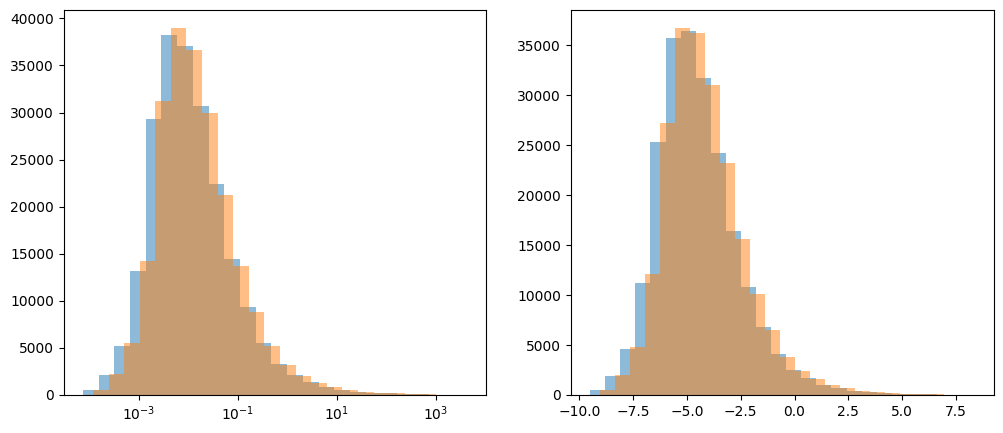

In [56]:
X = h*A
Y = np.sqrt(df['sig_sq'])

bins_X = np.logspace(np.log10(np.min(X)), np.log10(np.max(X)), 25)
bins_Y = np.logspace(np.log10(np.min(Y)), np.log10(np.max(Y)), 25)

fig,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].hist(X,bins = bins_X,alpha = 0.5)
ax[0].hist(Y,bins = bins_Y,alpha = 0.5)
ax[0].set_xscale('log')



ax[1].hist(np.log(X),bins = 25,alpha = 0.5)
ax[1].hist(np.log(Y),bins = 25,alpha = 0.5)